In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass 

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers

<b>Helping Functions</b><br>
Ignore these functions for now as they will be used later anyway. You can come back to them anytime you want.

In [11]:
from datetime import datetime
def show_generator_output(seed):
    fig = plt.figure(figsize=(15,5))
    images = generator(seed)
    for i, image in zip(range(10), images):
        fig.add_subplot(1,10,i+1).imshow(image[:,:, 0] * 127.5 + 127.5,interpolation="nearest", cmap='gray')
        plt.xticks([], [])
        plt.yticks([], [])
    plt.savefig(f"results/results_{str(datetime.now()).replace(':', '-').split('.')[0]}")
    plt.tight_layout()
    plt.show()

<b>Hyper Parameters</b>

In [2]:
batch_size = 256
codings_size = 100

<b> Load Dataset </b>

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)
m = train_images.shape[0]

train_images = train_images[:, :, :, :]
test_images = test_images[:, :, :, :]

<b> Create Generator and Discriminator Models </b>

In [4]:
seed = tf.random.normal([10, codings_size])

In [6]:
def create_generator_model():
    #     model = tf.keras.Sequential()
    #     model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(codings_size,)))
    #     model.add(layers.BatchNormalization())
    #     model.add(layers.LeakyReLU())

    #     model.add(layers.Reshape((7, 7, 256)))
    #     assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    #     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #     assert model.output_shape == (None, 7, 7, 128)
    #     model.add(layers.BatchNormalization())
    #     model.add(layers.LeakyReLU())

    #     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #     assert model.output_shape == (None, 14, 14, 64)
    #     model.add(layers.BatchNormalization())
    #     model.add(layers.LeakyReLU())

    #     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #     assert model.output_shape == (None, 28, 28, 1)
    #     generator_model = model
    generator_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
        tf.keras.layers.Dense(150, activation='selu'),
        tf.keras.layers.Dense(28*28, activation='sigmoid'),
        tf.keras.layers.Reshape([28,28, 1])
    ])
    return generator_model
def create_discriminator_model():
    #     model = tf.keras.Sequential()
    #     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
    #                                      input_shape=[28, 28, 1]))
    #     model.add(layers.LeakyReLU())
    #     model.add(layers.Dropout(0.3))

    #     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    #     model.add(layers.LeakyReLU())
    #     model.add(layers.Dropout(0.3))

    #     model.add(layers.Flatten())
    #     model.add(layers.Dense(1))
    #     discriminator_model = model
    discriminator_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[28,28, 1]),
        tf.keras.layers.Dense(150, activation='selu'),
        tf.keras.layers.Dense(100, activation='selu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return discriminator_model

gan = tf.keras.models.Sequential([create_generator_model(), create_discriminator_model()])
generator, discriminator = gan.layers

In [7]:
def generate_fake_images(m, generator_model):
    # Fake Images from the Generator
    random_fake_indexes = tf.random.normal([m, codings_size])
    random_fake_images = generator_model(random_fake_indexes, training=True)
    random_fake_labels = np.zeros((m, 1))
    return random_fake_images, random_fake_labels

def discriminator_training_forward_pass(train_images, generator_model):
    # Real Images from Database
    m = train_images.shape[0]
    random_real_indexes = np.random.randint(0, m, m)
    random_real_images = train_images[random_real_indexes, ...]
    random_real_labels = np.ones((m, 1))

    # Fake Images from the Generator
    random_fake_images, random_fake_labels = generate_fake_images(m, generator_model)
    
    assert random_fake_images.shape == random_real_images.shape, 'image shape problem'
    assert random_fake_labels.shape == random_real_labels.shape, "label shape problem"

    # Combining Real and Fake Images
    discriminator_images = np.vstack([random_real_images, random_fake_images])
    discriminator_labels = np.vstack([random_real_labels, random_fake_labels])

    # shuffling images
    indices = list(range(discriminator_images.shape[0]))
#     np.random.shuffle(indices)
    discriminator_images = discriminator_images[indices]
    discriminator_labels = discriminator_labels[indices]

    return discriminator_images, discriminator_labels

In [12]:
e = 0

epoch 55, disc batches: 5, gen batches: 8
	gen loss: 0.7221806645393372, dis loss: 0.3752114772796631


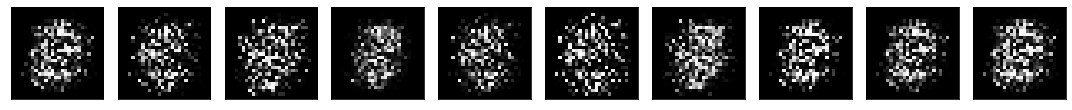

In [15]:
lr = 0.0001
while True:
    e+=1
    # Train Discriminator
    discriminator.trainable = True
    discriminator_batch_counter = 0
    while True: # batch
        discriminator_batch_counter+=1
        images = train_images[np.random.choice(range(0, m), batch_size), ...]

        with tf.GradientTape() as tape:
            discriminator_images, discriminator_labels = discriminator_training_forward_pass(images, generator)

            # Forward Pass Through Discriminator
            discriminator_output = discriminator(discriminator_images, training=True)

            discriminator_loss = tf.keras.losses.binary_crossentropy(discriminator_labels, discriminator_output)
            discriminator_loss = tf.reduce_mean(discriminator_loss)
            
        discriminator_gradients = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=lr)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_weights))

        predicted_labels = discriminator_output.numpy().flatten().round()
        acc_score = accuracy_score(discriminator_labels.flatten(), predicted_labels)
        
        if acc_score > 0.9:
            break


    # Train Generator
    discriminator.trainable = False
    generator_batch_counter = 0
    while True: # batch
        generator_batch_counter+=1
        images = train_images[np.random.choice(range(0, m), batch_size), ...]
        random_fake_indexes = tf.random.normal([batch_size, codings_size])
        true_labels = tf.ones([batch_size, 1])

        with tf.GradientTape() as tape:
            generator_images = generator(random_fake_indexes)

            # Forward Pass Through Discriminator
            discriminator_output = discriminator(generator_images, training=True)
            generator_loss = tf.keras.losses.binary_crossentropy(true_labels, discriminator_output)
            generator_loss = tf.reduce_mean(generator_loss)

        generator_gradients = tape.gradient(generator_loss, gan.trainable_weights)
        generator_optimizer = tf.keras.optimizers.RMSprop(lr=lr)
        generator_optimizer.apply_gradients(zip(generator_gradients, gan.trainable_weights))

        discriminator_output_labels = discriminator_output.numpy().round().flatten()
        acc_score = accuracy_score(true_labels, discriminator_output_labels)
        if acc_score > 0.4:
            break
    if e%5 == 0:
        clear_output()
        print(f"epoch {e}, disc batches: {discriminator_batch_counter}, gen batches: {generator_batch_counter}")
        print(f"\tgen loss: {generator_loss}, dis loss: {discriminator_loss}")
        show_generator_output(seed)
    if e%5 == 0:
        break

# Single Batch Training Setting

epoch 3, iteration 200, disc batches: 100, gen batches: 1
	gen loss: 0.2501157224178314, dis loss: 3.0806703854580064e-09


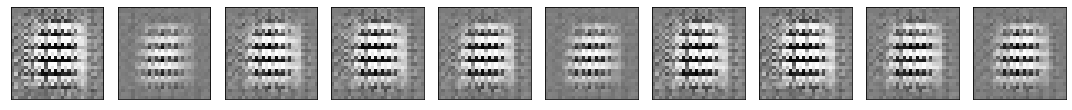

KeyboardInterrupt: 

In [61]:
e = 0
lr = 0.0001
while True:
    e+=1
    for i, idx in enumerate(range(0, m, batch_size)): # batch
        # Train Discriminator
        if i%100==0:
            clear_output()
            print(f"epoch {e}, iteration {i}, disc batches: {discriminator_batch_counter}, gen batches: {generator_batch_counter}")
            print(f"\tgen loss: {generator_loss}, dis loss: {discriminator_loss}")
            show_generator_output()            
        discriminator.trainable = True
        images = train_images[idx:idx+batch_size, ...]

        with tf.GradientTape() as tape:
            discriminator_images, discriminator_labels = discriminator_training_forward_pass(images, generator)
            
            # Forward Pass Through Discriminator
            discriminator_output = discriminator(discriminator_images, training=True)

            discriminator_loss = tf.keras.losses.binary_crossentropy(discriminator_labels, discriminator_output)
            discriminator_loss = tf.reduce_mean(discriminator_loss)
            
        discriminator_gradients = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        discriminator_optimizer = tf.keras.optimizers.RMSprop()
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_weights))


        # Train Generator
        discriminator.trainable = False
        generator_batch_counter = 0
        generator_batch_counter+=1
        random_fake_indexes = tf.random.normal([batch_size, codings_size])
        true_labels = tf.ones([batch_size, 1])

        with tf.GradientTape() as tape:
            generator_images = generator(random_fake_indexes)

            # Forward Pass Through Discriminator
            discriminator_output = discriminator(generator_images, training=True)
            discriminator_loss = tf.keras.losses.binary_crossentropy(true_labels, discriminator_output)
            discriminator_loss = tf.reduce_mean(discriminator_loss)

        generator_gradients = tape.gradient(discriminator_loss, gan.trainable_weights)
        generator_optimizer = tf.keras.optimizers.RMSprop()
        generator_optimizer.apply_gradients(zip(generator_gradients, gan.trainable_weights))
        
        
    if e%1 == 0:
        clear_output()
        print(f"epoch {e}")
        show_generator_output()

# Single Batch Training with Single Generator Example

In [83]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [84]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# @tf.function
def train_step(real_images):
    noise = tf.random.normal([batch_size, codings_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise)

        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))    
    # discriminator

In [85]:
# GAN continuously outputting single label: Mode Collapse
# reference article: https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432
"""
    problems: 
        1. Diminished gradient
        2. Non-convergence
        3. Mode collapse
"""

'\n    problems: \n        1. Diminished gradient\n        2. Non-convergence\n        3. Mode collapse\n'

In [86]:
# real_output
# fake_output

epoch: 99


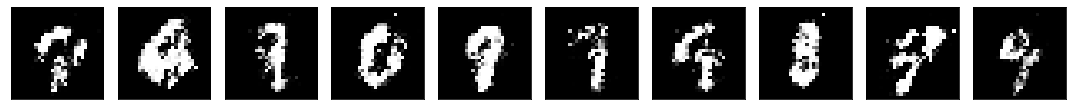

	batch: 0
	batch: 100
	batch: 200


In [87]:
epochs = 100
for epoch in range(epochs):
    clear_output()
    print(f"epoch: {epoch}")
    show_generator_output(seed)
    for i, idx in enumerate(range(0, m, batch_size)):
        if i%100==0:
            print(f"\tbatch: {i}")
            
        noise = tf.random.normal([batch_size, codings_size])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = generator(noise)

            real_output = discriminator(train_images[idx:idx+batch_size])
            fake_output = discriminator(fake_images)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))    


In [ ]:
"""
After training the discriminator and getting 1.0 accuracy, I should do the following
    - train generator with mse loss function
"""
discriminator_model(train_images.reshape(train_images.shape[0], -1)[0:10]), discriminator_model(np.random.rand(10,28,28,1))

In [434]:
# Train Generator

# convert to batches
generator_epochs = 100
loss_history = list()
for e in range(generator_epochs):
    # Training Generator
    discriminator_model.trainable = False
    generator_model.trainable = True
    m = train_images.shape[0]

    for idx in range(0, m, batch_size): # batch
        random_numbers = np.random.rand(batch_size, 1)
        true_labels = np.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            # Forward Pass Through Discriminator
            gan_outputs = gan(random_numbers)
            generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_labels, gan_outputs))
        loss_history.append(generator_loss)
        generator_gradients = tape.gradient(generator_loss, generator_model.trainable_weights)
        generator_optimizer = tf.keras.optimizers.RMSprop()
        generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_weights))
        acc_score = accuracy_score(true_labels, tf.round(gan_outputs).numpy().flatten())
        
        clear_output()
        print(f"epoch: {e}, acc_score: {np.round(acc_score, 2)}, generator loss: {np.round(generator_loss, 6)}")

epoch: 0, acc_score: 1.0, generator loss: 6.900000153109431e-05


KeyboardInterrupt: 

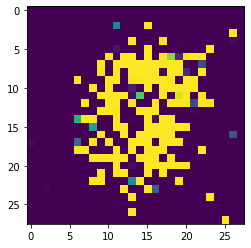

In [460]:
plt.imshow(generator_model(np.random.rand(1,1))[0])

In [36]:
tf.keras.losses.mse(random_real_images, random_fake_images).shape

TensorShape([60000, 28, 28])

In [29]:
random_real_images.shape

(60000, 28, 28, 1)

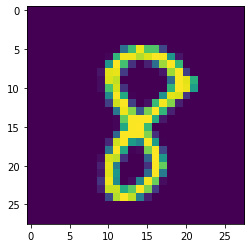

In [28]:
plt.imshow(random_real_images[1,:,:,0])

In [230]:
def plot_images(random_images):
    plt.figure(figsize=(15, 4))
    for i in range(batch_size):
        plt.subplot(2,16,i+1)
        plt.imshow(random_images[i][:,:,0])
        plt.axis('off')
        plt.grid(b=None)
    plt.tight_layout()
    plt.show()
plot_images(random_fake_images)
plot_images(random_real_images)

NameError: name 'random_fake_images' is not defined